In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tensorflow

from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *


pd.options.display.max_rows = 2000
pd.options.display.max_columns = 500

In [2]:
data = pd.read_csv("comments.csv")

Изучим входные данные

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


Посмотрим, сколько слов содержат в себе тексты

In [5]:
data['text_len'] = data['comment_text'].apply(lambda x: len(x.split(' ')))

In [6]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,68.094270
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,102.854801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2834.000000


Как видно, в средней тексты состоят из 68 слов, а также большая часть из них содержит менее 76 слов, но есть и тексты с 2834 словами

Посмотрим, что представляет из себя сообщение, которое имеет более 1000 слов в своем составе

In [7]:
data.loc[data['text_len'] > 1000, 'comment_text'].sample(1).values

array(['FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW 

Большинство таких коментариев содержат или повторяющие слова, или же множество побочных символов (например, иероглифы). Все лишнее мы уберем при токенизации. Также для стандартизации текста все следует перевести к одному регистру.

In [8]:
def custom_standardization(sentence):
    # приводим в нижний регистр
    sample = tensorflow.strings.lower(sentence)
    # убираем не словесные знаки (к словесным относятся буквы, цифры и т.д.)
    sample = tensorflow.strings.regex_replace(sample, '\W', ' ')
    # убираем цифры
    sample = tensorflow.strings.regex_replace(sample, '\d', ' ')
    # убираем знаки препинания
    return tensorflow.strings.regex_replace(sample,
                         '[%s]'%re.escape(string.punctuation), '')

Стоит также узнать, какой размерности стоит делать векторы для текста. Возьмем значение, которое покрывает достаточно большую часть коментариев.

(array([2.15941e+05, 5.18800e+03, 2.11800e+03, 2.53000e+02, 3.70000e+01,
        4.00000e+00, 0.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([1.0000e+00, 2.8430e+02, 5.6760e+02, 8.5090e+02, 1.1342e+03,
        1.4175e+03, 1.7008e+03, 1.9841e+03, 2.2674e+03, 2.5507e+03,
        2.8340e+03]),
 <BarContainer object of 10 artists>)

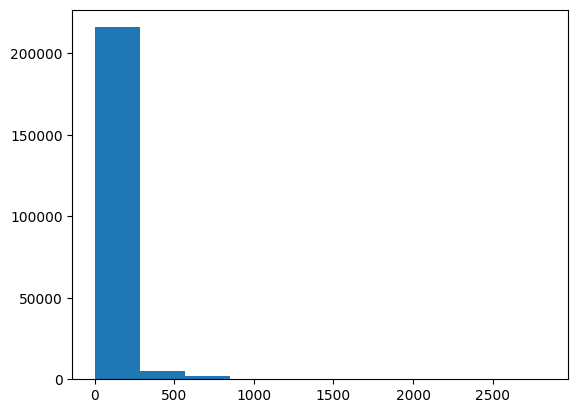

In [9]:
plt.hist(data['text_len'])

In [10]:
count_250 = len(data.loc[data['text_len'] < 250, 'text_len'])
count_500 = len(data.loc[data['text_len'] < 500, 'text_len'])

print(count_250, count_500)

213831 220488


Лучше будет взять 250 значений, так как покрывает достаточно большую часть слов, а разница между между 250 и 500 не настолько значительна, чтобы жертвовать производительностью

In [11]:
# не будем брать слишком большой словарь, чтобы не делать слишком больших вычислений
max_features = 10000
sequence_length = 250

In [12]:
# токенезируем предложения
vectorize_layer = tensorflow.keras.layers.TextVectorization(
                        standardize=custom_standardization,
                        split='whitespace',
                        max_tokens=max_features,
                        output_mode='int',
                        output_sequence_length=sequence_length,
                        encoding='utf-8')
vectorize_layer.adapt(data['comment_text'])

Разделим данные на тренировочные и тестовые

In [13]:
X = data["comment_text"]
Y = data[data.columns[2:-1]]

X = np.array(vectorize_layer(X))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Далее рассмотрим, какие модели можно применить для решения задачи.
Для классификации текстов часто используют CNN, LSTM, GRU (в некоторых ситуациях работает лучше, чем LSTM). 

Хоть мы будем рассматривать разные модели, однако у каждой из них будет слой ембединга (для определения связи между словами)

Начнем с CNN. такие сети содержат в себе несколько разных слоев. 


In [14]:
embedding_dim = 9
# экспериментальным путем было установлено, что значения 9 достаточно
# например, при 16 не было значительного улучшения в точности, но было небольшое увеличение времени обучения
# например, при 4 иногда начинала страдать точность модели

In [15]:
cnn_model = Sequential()
# сначала ембединг
cnn_model.add(Embedding(max_features+1, embedding_dim))
# далее уменьшим размерность
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dense(16, activation='relu'))
# слой для вывода результата. сигмоида для того, чтобы попасть в рамки [0, 1]
# в остальных моделях последним слоем также будет сигмоида
cnn_model.add(Dense(6, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 9)           90009     
                                                                 
 global_average_pooling1d (G  (None, 9)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 90,271
Trainable params: 90,271
Non-trainable params: 0
_________________________________________________________________


In [16]:
cnn_epochs = 5
# после 4-5 эпох точность не увеличивалась

history = cnn_model.fit(X_train, y_train, epochs=cnn_epochs, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/5
350/350 [==============================] - 4s 10ms/step - loss: 0.3219 - accuracy: 0.2005 - val_loss: 0.1383 - val_accuracy: 0.9951
Epoch 2/5
350/350 [==============================] - 4s 10ms/step - loss: 0.1378 - accuracy: 0.9951 - val_loss: 0.1330 - val_accuracy: 0.9951
Epoch 3/5
350/350 [==============================] - 4s 11ms/step - loss: 0.1328 - accuracy: 0.9950 - val_loss: 0.1269 - val_accuracy: 0.9952
Epoch 4/5
350/350 [==============================] - 4s 13ms/step - loss: 0.1245 - accuracy: 0.9951 - val_loss: 0.1174 - val_accuracy: 0.9952
Epoch 5/5
350/350 [==============================] - 4s 13ms/step - loss: 0.1120 - accuracy: 0.9951 - val_loss: 0.1052 - val_accuracy: 0.9952


Возьмем некоторые показатели точности модели

In [17]:
cnn_prediction = cnn_model.predict(X_test)
cnn_model.get_metrics_result()

1398/1398 [==============================] - 2s 1ms/step


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.10521577>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9951912>}

Вывод по модели: она работает достаточно быстро (обучение одной эпохи занимает 5-7 секунд), обладает высокой точностью

Далее будет LSTM 

In [18]:
lstm_epochs = 5
# аналогично после 4-5 эпох особого прироста в точности не было

lstm_model = Sequential()
lstm_model.add(Embedding(max_features+1, embedding_dim))
lstm_model.add(LSTM(16))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(6, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 9)           90009     
                                                                 
 lstm (LSTM)                 (None, 16)                1664      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 92,047
Trainable params: 92,047
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = lstm_model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/5
350/350 [==============================] - 54s 147ms/step - loss: 0.2143 - accuracy: 0.6935 - val_loss: 0.1399 - val_accuracy: 0.9952
Epoch 2/5
350/350 [==============================] - 53s 151ms/step - loss: 0.1450 - accuracy: 0.9717 - val_loss: 0.1398 - val_accuracy: 0.9950
Epoch 3/5
350/350 [==============================] - 51s 145ms/step - loss: 0.1442 - accuracy: 0.9887 - val_loss: 0.1392 - val_accuracy: 0.9949
Epoch 4/5
350/350 [==============================] - 50s 142ms/step - loss: 0.1437 - accuracy: 0.9933 - val_loss: 0.1396 - val_accuracy: 0.9946
Epoch 5/5
350/350 [==============================] - 50s 142ms/step - loss: 0.1424 - accuracy: 0.9941 - val_loss: 0.1384 - val_accuracy: 0.9943


Возьмем некоторые показатели точности модели

In [20]:
lstm_prediction = lstm_model.predict(X_test)
lstm_model.get_metrics_result()

1398/1398 [==============================] - 20s 14ms/step


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.13835494>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.99425185>}

Вывод по модели: LSTM работает намного медленнее CNN, при этом не обладая сильным преимуществом по точности

Рассмотрим GRU

In [21]:
gru_epochs = 5
# аналогично моделям выше

gru_model = Sequential()
gru_model.add(Embedding(max_features+1, embedding_dim))
gru_model.add(GRU(16))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(6, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 9)           90009     
                                                                 
 gru (GRU)                   (None, 16)                1296      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 91,679
Trainable params: 91,679
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = gru_model.fit(X_train, y_train, epochs=gru_epochs, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/5
350/350 [==============================] - 46s 126ms/step - loss: 0.2234 - accuracy: 0.8980 - val_loss: 0.1396 - val_accuracy: 0.9952
Epoch 2/5
350/350 [==============================] - 43s 123ms/step - loss: 0.1455 - accuracy: 0.9486 - val_loss: 0.1389 - val_accuracy: 0.9949
Epoch 3/5
350/350 [==============================] - 43s 122ms/step - loss: 0.1440 - accuracy: 0.9905 - val_loss: 0.1381 - val_accuracy: 0.9943
Epoch 4/5
350/350 [==============================] - 43s 122ms/step - loss: 0.1382 - accuracy: 0.9944 - val_loss: 0.0969 - val_accuracy: 0.9952
Epoch 5/5
350/350 [==============================] - 43s 123ms/step - loss: 0.0690 - accuracy: 0.9951 - val_loss: 0.0576 - val_accuracy: 0.9952


Возьмем некоторые метрики

In [23]:
gru_prediction = gru_model.predict(X_test)
gru_model.get_metrics_result()

1398/1398 [==============================] - 16s 11ms/step


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.057555176>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9951912>}

Вывод по модели: работает медленней, чем CNN, но быстрее чем LSTM, не обладает серьезным преимуществом в точности